In [11]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os

In [12]:
absolute_path = os.path.join(os.getcwd(), '/mnist')

In [13]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(os.getcwd(), transform=transform, download=True)
test_dataset  = MNIST(os.getcwd(), transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

one_image_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) # For visualising

In [14]:
def plot_image(tensor):

    if tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)

    image = tensor.numpy()


    plt.imshow(image, cmap='gray' if tensor.ndim == 2 else None)
    plt.axis('off')
    plt.show()

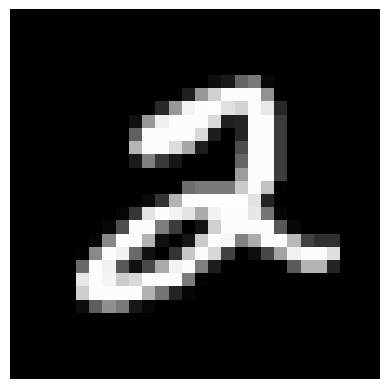

In [15]:
plot_image(train_dataset[5][0])

# Autoencoder:

In [47]:
class GaussianAutoEncodingVariationalBayes(nn.Module):
    def __init__(self, input_dim, hidden_layers, inter_dim = 256, classification = False):
        super(GaussianAutoEncodingVariationalBayes, self).__init__()

        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.inter_dim = inter_dim

        # Appendix C.2, switch-out Z with X as described ============================
        self.encoder_mlp = nn.Sequential(
            nn.Linear(self.input_dim, inter_dim), # Here are the weights W_3 that make up phi
            nn.Tanh(),
        )

        self.latent_u_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_4 that make up phi
        self.latent_variance_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_5 that make up phi
        # ===========================================================================


        # Appendix C.2, implemented exactly in this way ---------------------------------
        self.decoder_mlp = nn.Sequential(
            nn.Linear(hidden_layers, inter_dim), # Here are the weights W_3 that make up theta
            nn.Tanh()
        )

        if classification:
            self.output_u_prediction_head = nn.Sequential(
            nn.Linear(inter_dim, input_dim), # Here are the weights W_4 that make up theta
            nn.Sigmoid() # Page 6 last sentence explains this part
            )
        else:
            nn.Linear(inter_dim,input_dim) # Here are the weights W_4 that make up theta

        self.output_variance_prediction_head = nn.Linear(inter_dim, input_dim) # Here are the weights W_5 that make up theta
        # ---------------------------------------------------------------------------------

    def encoder_forward(self, X):
        h = self.encoder_mlp(X)
        latent_u = self.latent_u_prediction_head(h)
        latent_variance = self.latent_variance_prediction_head(h)

        latent_logvariance = torch.log(latent_variance)

        return latent_u, latent_logvariance # These are the estimates of parameters for q_phi(Z|X) ~ N(latent_u, latent_variance)

    def decoder_forward(self, latent_u, latent_logvariance, sampled_error_e = 0):
        Z = latent_u + torch.sqrt(torch.exp(latent_logvariance))*sampled_error_e # Latent variables Z
        # We sample from prior only during training, so during prediction Z = latent_u

        h = self.decoder_mlp(Z)
        output_u = self.output_u_prediction_head(h) # This is the main prediction of X_hat
        output_variance = self.output_variance_prediction_head(h) # Not needed to reconstruct, but gives us an estimate of the variance

        output_logvariance = torch.log(output_variance)

        return output_u, output_logvariance # These are the estimates of parameters for p_theta(X|Z) ~ N(output_u, output_variance)

    def sample_from_prior(self):
        samples = torch.randn(self.hidden_layers) # This is a prior p(Z) ~ N(0,1)
        return samples

    def forward(self, X):
        latent_u, latent_logvariance = self.encoder_forward(X)
        sampled_error_e = self.sample_from_prior()
        X_hat, logvariance = self.decoder_forward(latent_u, latent_logvariance, sampled_error_e)
        return X_hat, logvariance, latent_u, latent_logvariance

In [48]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Testing whether the VAE works:

In [49]:
GVAE = GaussianAutoEncodingVariationalBayes(784, 2, classification=True)
GVAE.apply(init_weights)


single_image, _ = next(iter(one_image_loader))
single_image = single_image.view(single_image.size(0),-1)

GVAE(single_image)[0]

tensor([[0.5029, 0.5131, 0.5011, 0.5015, 0.5033, 0.5036, 0.5029, 0.5021, 0.5033,
         0.4980, 0.5043, 0.5048, 0.5006, 0.5030, 0.5076, 0.5026, 0.5001, 0.5016,
         0.5022, 0.5024, 0.5005, 0.4977, 0.4997, 0.4991, 0.4968, 0.5035, 0.5041,
         0.5034, 0.5010, 0.5012, 0.5025, 0.5032, 0.5033, 0.5037, 0.5020, 0.4981,
         0.5006, 0.5024, 0.5073, 0.5063, 0.4997, 0.5021, 0.5002, 0.5006, 0.5058,
         0.5005, 0.5046, 0.5006, 0.5017, 0.5064, 0.5066, 0.5025, 0.5007, 0.5024,
         0.5019, 0.5000, 0.5047, 0.5029, 0.5023, 0.5049, 0.4975, 0.5056, 0.5064,
         0.5023, 0.5035, 0.4984, 0.5014, 0.5021, 0.4982, 0.4977, 0.5036, 0.5005,
         0.5065, 0.4987, 0.5026, 0.5049, 0.5054, 0.4999, 0.5020, 0.5037, 0.5051,
         0.5051, 0.5042, 0.5058, 0.5003, 0.5049, 0.4999, 0.5047, 0.4989, 0.5030,
         0.5026, 0.5035, 0.5060, 0.5031, 0.5059, 0.5006, 0.5033, 0.5065, 0.5013,
         0.5021, 0.4997, 0.4997, 0.5061, 0.5056, 0.4999, 0.5036, 0.5018, 0.5007,
         0.4991, 0.5020, 0.5

In [50]:
single_image

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0902, 0.7020,
         0.8000, 0.1176, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4157,
         0.9961, 0.9137, 0.1176, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

# Gaussian Loss function:

In [51]:
def gaussian_log_likelihood(X, X_hat, logvar):
    reconstruction_loss = torch.sum(-0.5 * (torch.log(2 * torch.pi) + logvar + (X - X_hat) ** 2 / torch.exp(logvar)))
    return reconstruction_loss / X.size(0)  # Normalize by batch size


def kullback_leiber_divergence(latent_u, latent_logvar):
    kl_div = -0.5 * torch.sum(1 + latent_logvar - latent_u.pow(2) - latent_logvar.exp())
    return kl_div

# Gaussian Training

In [ ]:
GVAE = GaussianAutoEncodingVariationalBayes(784, 2, classification = True)
GVAE.apply(init_weights)
epochs = 5-